In [24]:
import numpy as np
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt

In [25]:
def orbit_rv(nu, q_rstar, t_cen, t, e=1.0, m_star=1.7, r_star=1.5, testing=False):
    '''RVs during transit, parabolic or elliptical.
    
    Parameters
    ----------
    nu : float
        Pericenter angle from center of transit.
    q_rstar : float
        Pericenter in stellar radii.
    t_cen : float
        Time at transit mid-point in hours (where f = -nu).
    t : ndarray
        Times at which to calculate RV.
    e : float
        Orbit eccentricity, if =1 will use parabolic functions.
    '''
    
    # some constants
    mu = const.G.value * m_star * u.M_sun.to('kg')
    q = q_rstar * r_star * u.R_sun.to('m')
    if e == 1:
        h = np.sqrt(2*mu*q)
    else:
        a = q / (1-e)
        h = np.sqrt(mu*a*(1-e**2))
    
    # time to pericenter from transit center, and true anomaly at times t
    if e == 1:
        t_to_cen = t_at_f_para(mu, q, -nu)
        f = f_at_t_para(mu, q, t_to_cen + (t - t_cen)*3600 )
    else:
        t_to_cen = t_at_f_ellip(mu, q, e, -nu)
        f = f_at_t_ellip(mu, q, e, t_to_cen + (t - t_cen)*3600 )
        
    # is planet in front of star?
    if e == 1:
        r = 2 * q / (1+np.cos(f))
    else:
        r = a*(1-e**2)/(1+e*np.cos(f))
        
    x = r * np.cos(f)
    y = r * np.sin(f)
    bigx =  x * np.sin(nu) + y * np.cos(nu)
    bigy = -x * np.cos(nu) + y * np.sin(nu)
    in_transit = ( np.abs(bigx) < ( r_star * u.R_sun.to('m') ) ) & \
                 ( bigy < 0 )
    
    # compute RVs
    rv = mu / h * (np.sin(f)*np.cos(nu) + np.sin(nu)*(e+np.cos(f)))

    # acceleration at mid-transit
    acc = mu / bigy**2

    if testing:
        return in_transit, rv, t_to_cen, f, r/(r_star * u.R_sun.to('m')), x, bigy, acc
    else:
        return in_transit, rv

def t_at_f_ellip(mu, q, e, f):
    '''Return time to pericenter from true anomaly.'''
    n = np.sqrt(mu*((1-e)/q)**3)
    m = convfm(f, e)
    return m / n

def convfm(f_in,ecc):
    '''Convert true to mean anomaly.'''
    tf2 = np.tan(0.5*f_in)
    fact = np.sqrt( (1.0+ecc)/(1.0-ecc) )
    bige = 2.0*np.arctan2(tf2,fact)
    bigm = bige - ecc*np.sin(bige)
    return bigm

def f_at_t_ellip(mu, q, e, dt):
    '''Return true anomaly at time from/to pericenter'''
    n = np.sqrt(mu*((1-e)/q)**3)
    m = n * dt
#     f = np.array([convmf(mi, e) for mi in m])
    f = convmf_array(m, e)
    return f

def convmf_array(m_in, e_in):
    """Convert array of mean to true anomaly (for single e).
        
    Copy of bound orbit part of GMKs IDL straight copy of Vallado's 
    C++ routine.
    """

    m = np.array(m_in) % (2. * np.pi)
    numiter = 50
    small = 0.00000001
    if e_in > small:

        ecc = e_in * 1.0

#       ;; /* ------------  initial guess ------------- */
        e0 = m + ecc
        lo = np.logical_or( (m < 0.0) & (m > -np.pi), m > np.pi)
        e0[lo] = m[lo] - ecc

        ktr = 1
        e1  = e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0))
        while (np.max(np.abs(e1 - e0)) > small) & (ktr <= numiter):
            ktr += 1
            do = np.abs(e1 - e0) > small
            e0[do] = e1[do]
            e1[do] = e0[do] + (m[do] - e0[do] + ecc * np.sin(e0[do])) / (1.0 - ecc * np.cos(e0[do]))

#       ;; /* ---------  find true anomaly  ----------- */
        sinv = (np.sqrt(1.0 - ecc * ecc) * np.sin(e1)) / (1.0-ecc * np.cos(e1))
        cosv = (np.cos(e1) - ecc) / (1.0 - ecc * np.cos(e1))
        nu   = np.arctan2( sinv, cosv)
            
    else:
#       ;; /* --------------------- circular --------------------- */
        ktr = 0
        nu  = m
        e0  = m

    if ktr > numiter:
        print('WARNING: convmf did not converge')
        
    return nu

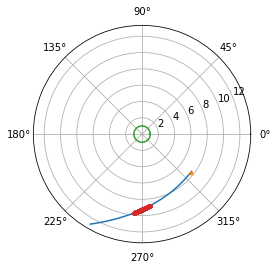

In [129]:
# some tests that things make sense, we are looking up from -Y here
nu = 0.9#np.pi/4.#1.00
q = 7.6 # Pericenter distance in stellar radii
in_tr, vel, dt, f, r, x, bigy, acc = orbit_rv(nu, q, 10, np.arange(0,20,0.01), e=0.9, testing=True)

fig = plt.figure()
ax = plt.subplot(projection='polar')
ax.plot(f-(np.pi/2-nu), r)
ax.plot(-(np.pi/2-nu), q, '.')
ax.plot(np.linspace(0,2*np.pi,100),np.ones(100))
if np.sum(in_tr) > 0:
    ax.plot(f[in_tr]-(np.pi/2-nu), r[in_tr], '.')



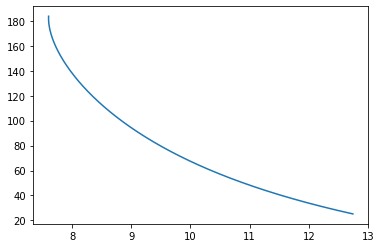

In [130]:
plt.plot(r,vel/1000.0) #km/s
#plt.ylim(0,610)

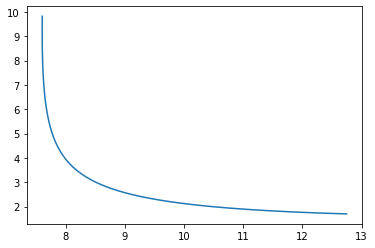

In [131]:
plt.plot(r,acc) #km/s
#plt.xlim(4,8)
#plt.ylim(0,40)